## 1. Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
from spotoptim import SpotOptim
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern

np.random.seed(42)
plt.rcParams['figure.figsize'] = (12, 6)
print("✓ Setup complete!")

✓ Setup complete!


In [2]:
# Test function
def branin(X):
    X = np.atleast_2d(X)
    x1, x2 = X[:, 0], X[:, 1]
    return (x2 - 5.1/(4*np.pi**2)*x1**2 + 5/np.pi*x1 - 6)**2 + 10*(1-1/(8*np.pi))*np.cos(x1) + 10

print("✓ Branin function loaded")

✓ Branin function loaded


## 2. Expected Improvement (EI)

### 2.1 Mathematical Derivation

**Goal:** Maximize expected improvement over current best $f^*$

Given GP prediction $f(x) \sim \mathcal{N}(\mu(x), \sigma^2(x))$:

$$I(x) = \max(f^* - f(x), 0)$$

$$\text{EI}(x) = \mathbb{E}[I(x)]$$

**Closed-form solution:**

$$\text{EI}(x) = \begin{cases}
(f^* - \mu(x))\Phi(Z) + \sigma(x)\phi(Z) & \text{if } \sigma(x) > 0 \\
0 & \text{if } \sigma(x) = 0
\end{cases}$$

where:
- $Z = \frac{f^* - \mu(x)}{\sigma(x)}$
- $\Phi(\cdot)$ is the standard normal CDF
- $\phi(\cdot)$ is the standard normal PDF

### 2.2 Implementation

In [3]:
def expected_improvement(X, gp, f_best, xi=0.01):
    """
    Expected Improvement acquisition function.
    
    Parameters:
    -----------
    X : array-like, shape (n_samples, n_features)
        Points to evaluate
    gp : GaussianProcessRegressor
        Fitted GP model
    f_best : float
        Best observed value so far
    xi : float
        Exploration parameter (default: 0.01)
    
    Returns:
    --------
    ei : array-like, shape (n_samples,)
        EI values
    """
    mu, sigma = gp.predict(X, return_std=True)
    
    # Add small exploration bonus
    mu_best = f_best - xi
    
    with np.errstate(divide='warn'):
        Z = (mu_best - mu) / sigma
        ei = (mu_best - mu) * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0
    
    return ei

print("✓ Expected Improvement function defined")

✓ Expected Improvement function defined


### 2.3 Properties of EI

**Advantages:**
- ✅ Automatic exploration-exploitation balance
- ✅ Differentiable (gradient-based optimization possible)
- ✅ Well-studied theoretical properties
- ✅ Works well in practice

**Trade-offs:**
- Two components:
  - $(f^* - \mu(x))\Phi(Z)$: Exploitation (expected gain)
  - $\sigma(x)\phi(Z)$: Exploration (uncertainty bonus)
- Parameter $\xi$ controls exploration intensity

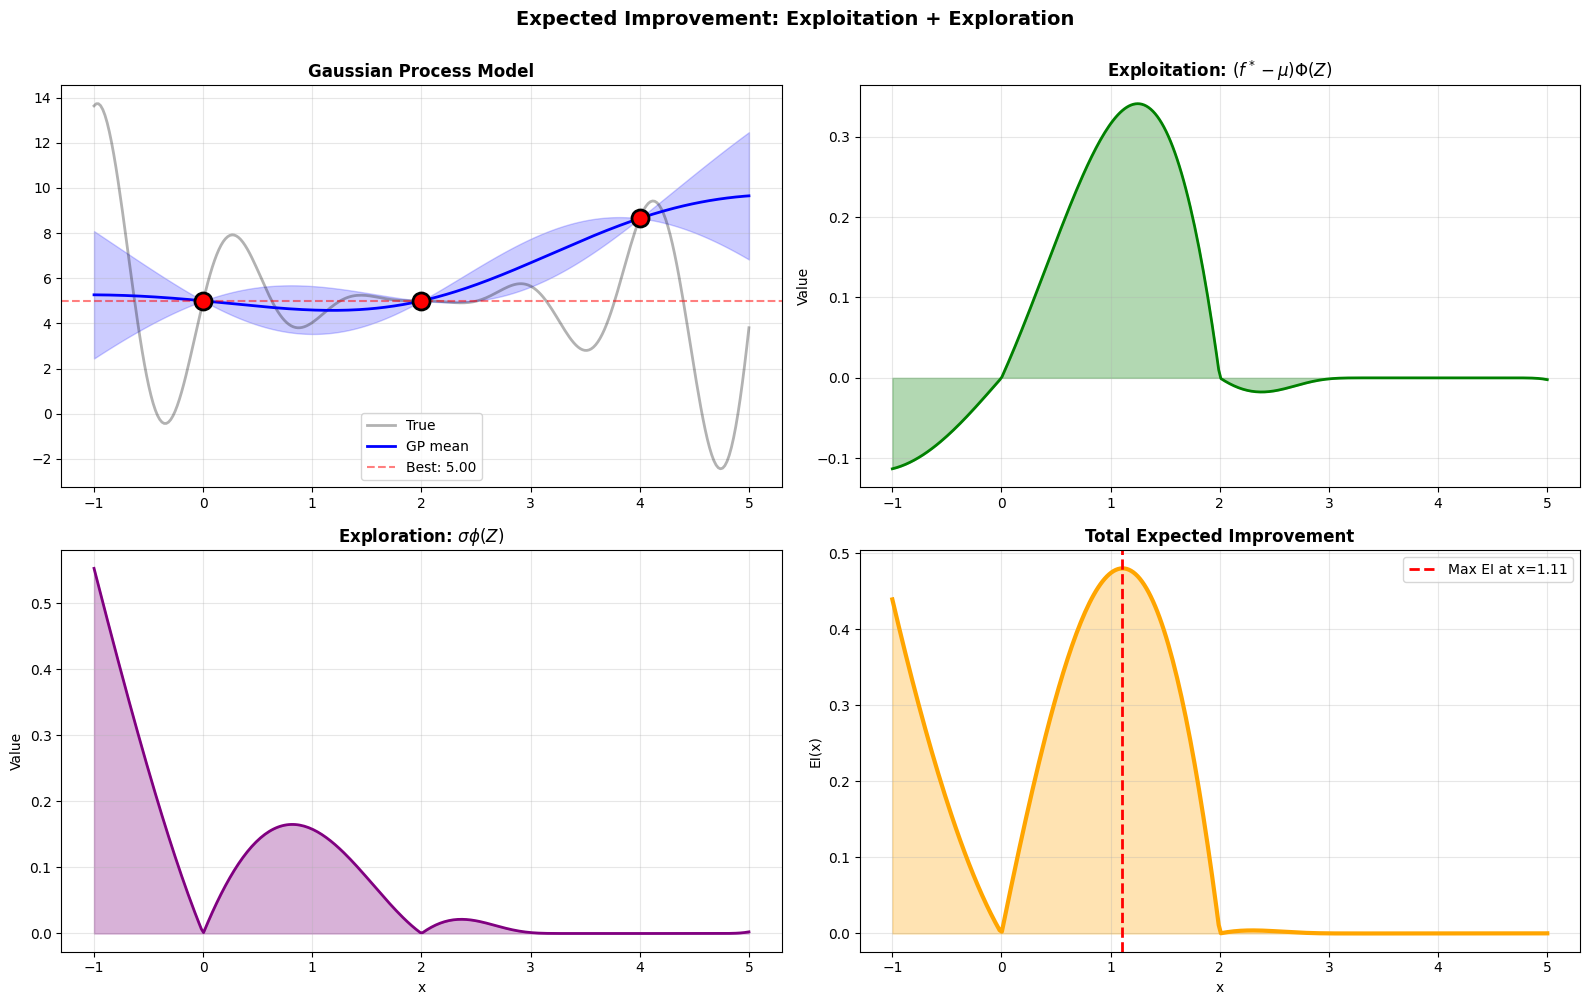


💡 EI balances both components automatically
   Max exploitation at: x = 1.25
   Max exploration at:  x = -1.00
   Max EI at:           x = 1.11


In [4]:
# Visualize EI components
def demo_1d_function(x):
    return (x - 2)**2 * np.sin(5*x) + 5

# Training data
X_train_ei = np.array([0, 2, 4]).reshape(-1, 1)
y_train_ei = demo_1d_function(X_train_ei.ravel())

# Fit GP
gp_ei = GaussianProcessRegressor(kernel=ConstantKernel(1.0) * Matern(nu=2.5), n_restarts_optimizer=10)
gp_ei.fit(X_train_ei, y_train_ei)

# Predict
X_plot_ei = np.linspace(-1, 5, 300).reshape(-1, 1)
mu_ei, sigma_ei = gp_ei.predict(X_plot_ei, return_std=True)

# Compute EI components
f_best_ei = np.min(y_train_ei)
Z_ei = (f_best_ei - mu_ei) / (sigma_ei + 1e-9)
exploitation = (f_best_ei - mu_ei) * norm.cdf(Z_ei)
exploration = sigma_ei * norm.pdf(Z_ei)
ei_total = exploitation + exploration
ei_total[sigma_ei < 1e-9] = 0

# Plot
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# GP model
axes[0, 0].plot(X_plot_ei, demo_1d_function(X_plot_ei.ravel()), 'k-', linewidth=2, alpha=0.3, label='True')
axes[0, 0].plot(X_plot_ei, mu_ei, 'b-', linewidth=2, label='GP mean')
axes[0, 0].fill_between(X_plot_ei.ravel(), mu_ei - 2*sigma_ei, mu_ei + 2*sigma_ei, alpha=0.2, color='blue')
axes[0, 0].scatter(X_train_ei, y_train_ei, s=150, c='red', zorder=5, edgecolors='black', linewidth=2)
axes[0, 0].axhline(f_best_ei, color='red', linestyle='--', alpha=0.5, label=f'Best: {f_best_ei:.2f}')
axes[0, 0].set_title('Gaussian Process Model', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Exploitation component
axes[0, 1].plot(X_plot_ei, exploitation, 'g-', linewidth=2)
axes[0, 1].fill_between(X_plot_ei.ravel(), 0, exploitation, alpha=0.3, color='green')
axes[0, 1].set_title('Exploitation: $(f^* - \\mu)\\Phi(Z)$', fontweight='bold')
axes[0, 1].set_ylabel('Value')
axes[0, 1].grid(True, alpha=0.3)

# Exploration component
axes[1, 0].plot(X_plot_ei, exploration, 'purple', linewidth=2)
axes[1, 0].fill_between(X_plot_ei.ravel(), 0, exploration, alpha=0.3, color='purple')
axes[1, 0].set_title('Exploration: $\\sigma\\phi(Z)$', fontweight='bold')
axes[1, 0].set_xlabel('x')
axes[1, 0].set_ylabel('Value')
axes[1, 0].grid(True, alpha=0.3)

# Total EI
axes[1, 1].plot(X_plot_ei, ei_total, 'orange', linewidth=3)
axes[1, 1].fill_between(X_plot_ei.ravel(), 0, ei_total, alpha=0.3, color='orange')
ei_max_idx = np.argmax(ei_total)
axes[1, 1].axvline(X_plot_ei[ei_max_idx], color='red', linestyle='--', linewidth=2, 
                   label=f'Max EI at x={X_plot_ei[ei_max_idx, 0]:.2f}')
axes[1, 1].set_title('Total Expected Improvement', fontweight='bold')
axes[1, 1].set_xlabel('x')
axes[1, 1].set_ylabel('EI(x)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Expected Improvement: Exploitation + Exploration', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print(f"\n💡 EI balances both components automatically")
print(f"   Max exploitation at: x = {X_plot_ei[np.argmax(exploitation), 0]:.2f}")
print(f"   Max exploration at:  x = {X_plot_ei[np.argmax(exploration), 0]:.2f}")
print(f"   Max EI at:           x = {X_plot_ei[ei_max_idx, 0]:.2f}")

## 3. Probability of Improvement (PI)

### 3.1 Mathematical Derivation

**Goal:** Maximize probability of improvement over $f^*$

$$\text{PI}(x) = P(f(x) < f^* - \xi) = \Phi\left(\frac{f^* - \xi - \mu(x)}{\sigma(x)}\right)$$

where $\xi \geq 0$ is an exploration parameter.

### 3.2 Properties

**Advantages:**
- ✅ Simple, intuitive
- ✅ Fast to compute

**Disadvantages:**
- ⚠️ Ignores magnitude of improvement
- ⚠️ Can be overly exploitative
- ⚠️ Less exploration than EI

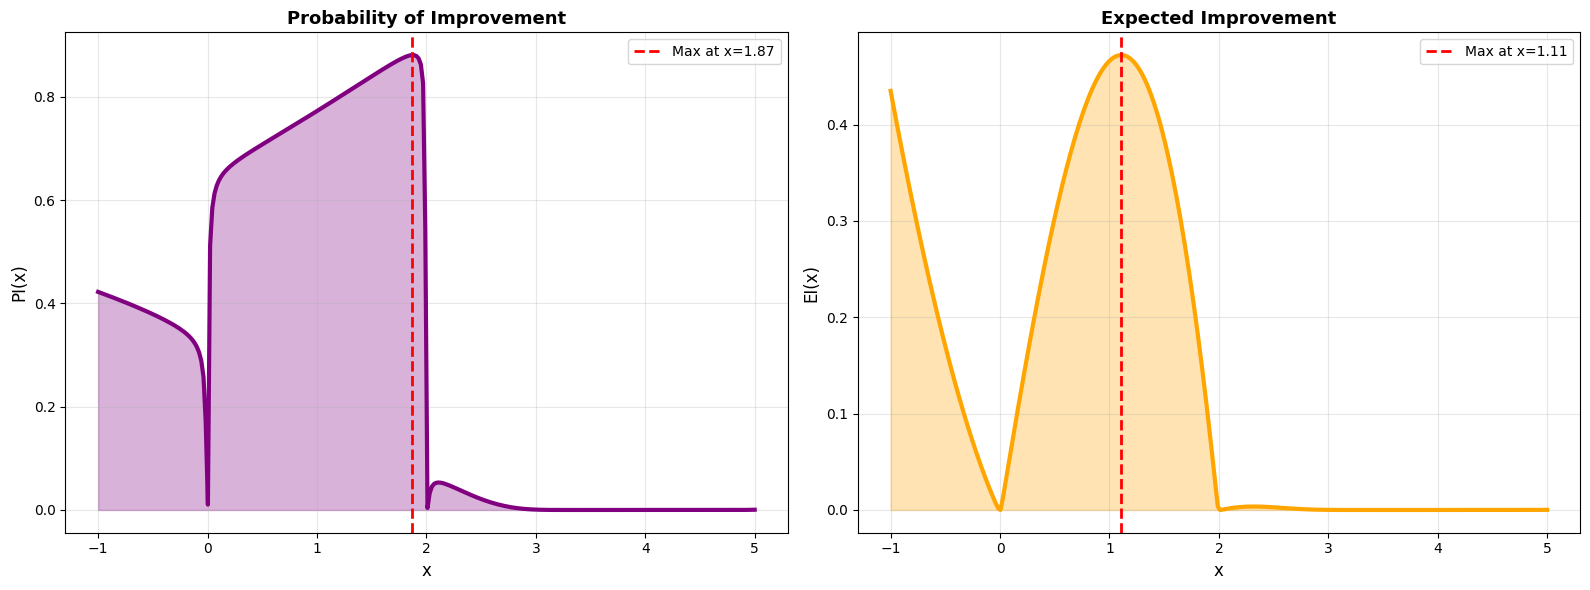


📊 Comparison:
   PI suggests: x = 1.87
   EI suggests: x = 1.11

💡 PI often more exploitative than EI


In [5]:
def probability_of_improvement(X, gp, f_best, xi=0.01):
    """Probability of Improvement acquisition function."""
    mu, sigma = gp.predict(X, return_std=True)
    
    with np.errstate(divide='warn'):
        Z = (f_best - xi - mu) / sigma
        pi = norm.cdf(Z)
        pi[sigma == 0.0] = 0.0
    
    return pi

# Compare PI with EI
pi_vals = probability_of_improvement(X_plot_ei, gp_ei, f_best_ei, xi=0.01)
ei_vals = expected_improvement(X_plot_ei, gp_ei, f_best_ei, xi=0.01)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# PI
ax1.plot(X_plot_ei, pi_vals, 'purple', linewidth=3)
ax1.fill_between(X_plot_ei.ravel(), 0, pi_vals, alpha=0.3, color='purple')
pi_max_idx = np.argmax(pi_vals)
ax1.axvline(X_plot_ei[pi_max_idx], color='red', linestyle='--', linewidth=2,
            label=f'Max at x={X_plot_ei[pi_max_idx, 0]:.2f}')
ax1.set_xlabel('x', fontsize=12)
ax1.set_ylabel('PI(x)', fontsize=12)
ax1.set_title('Probability of Improvement', fontweight='bold', fontsize=13)
ax1.legend()
ax1.grid(True, alpha=0.3)

# EI for comparison
ax2.plot(X_plot_ei, ei_vals, 'orange', linewidth=3)
ax2.fill_between(X_plot_ei.ravel(), 0, ei_vals, alpha=0.3, color='orange')
ei_max_idx_comp = np.argmax(ei_vals)
ax2.axvline(X_plot_ei[ei_max_idx_comp], color='red', linestyle='--', linewidth=2,
            label=f'Max at x={X_plot_ei[ei_max_idx_comp, 0]:.2f}')
ax2.set_xlabel('x', fontsize=12)
ax2.set_ylabel('EI(x)', fontsize=12)
ax2.set_title('Expected Improvement', fontweight='bold', fontsize=13)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Comparison:")
print(f"   PI suggests: x = {X_plot_ei[pi_max_idx, 0]:.2f}")
print(f"   EI suggests: x = {X_plot_ei[ei_max_idx_comp, 0]:.2f}")
print(f"\n💡 PI often more exploitative than EI")

## 4. Upper/Lower Confidence Bound (UCB/LCB)

### 4.1 Mathematical Form

For minimization, use **Lower Confidence Bound**:

$$\text{LCB}(x) = \mu(x) - \kappa \sigma(x)$$

For maximization, use **Upper Confidence Bound**:

$$\text{UCB}(x) = \mu(x) + \kappa \sigma(x)$$

where $\kappa > 0$ controls exploration.

### 4.2 Properties

**Advantages:**
- ✅ Explicit exploration-exploitation control via $\kappa$
- ✅ Theoretical guarantees (regret bounds)
- ✅ Simple, fast to compute

**Guidelines:**
- $\kappa = 1$: Balanced
- $\kappa = 2$: More exploration (typical choice)
- $\kappa = 0.5$: More exploitation

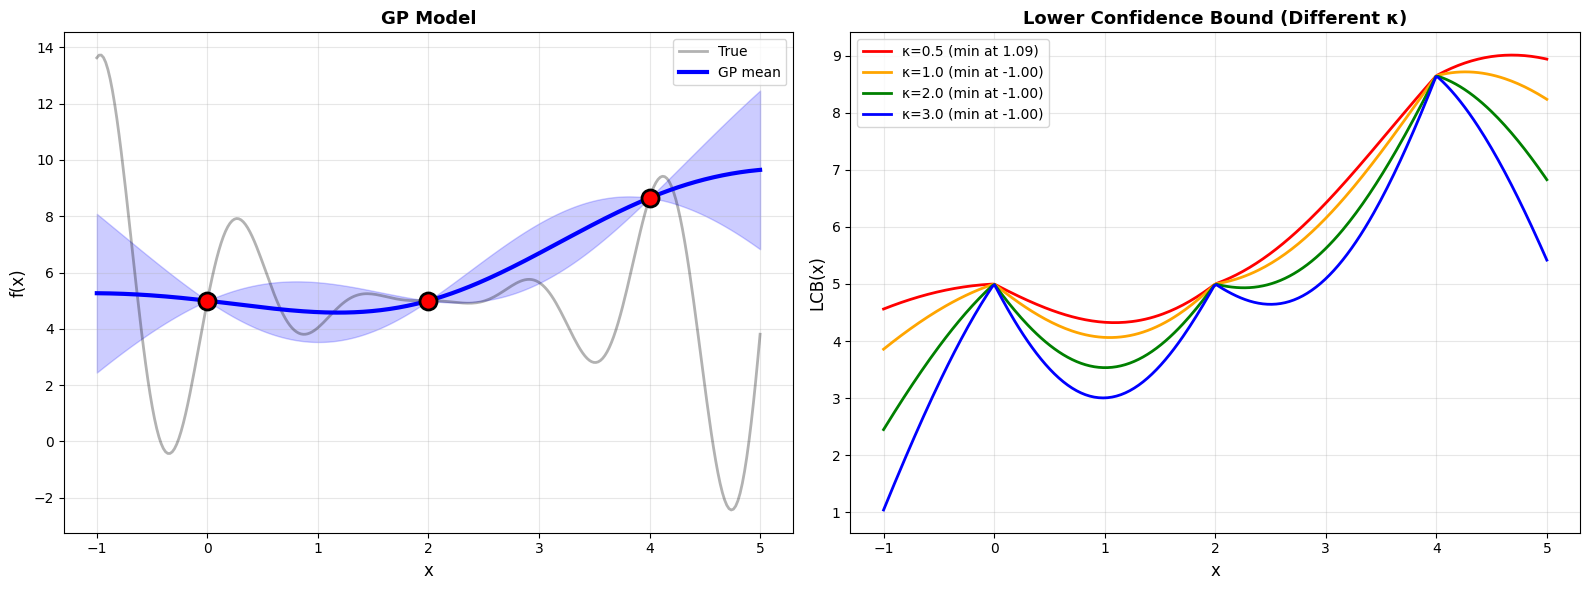


💡 Effect of κ:
   Small κ → More exploitation (trust mean)
   Large κ → More exploration (favor uncertainty)


In [6]:
def lower_confidence_bound(X, gp, kappa=2.0):
    """Lower Confidence Bound acquisition function (for minimization)."""
    mu, sigma = gp.predict(X, return_std=True)
    return mu - kappa * sigma

# Compare different kappa values
kappas = [0.5, 1.0, 2.0, 3.0]
colors_kappa = ['red', 'orange', 'green', 'blue']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# GP model
ax1.plot(X_plot_ei, demo_1d_function(X_plot_ei.ravel()), 'k-', linewidth=2, alpha=0.3, label='True')
ax1.plot(X_plot_ei, mu_ei, 'b-', linewidth=3, label='GP mean')
ax1.fill_between(X_plot_ei.ravel(), mu_ei - 2*sigma_ei, mu_ei + 2*sigma_ei, alpha=0.2, color='blue')
ax1.scatter(X_train_ei, y_train_ei, s=150, c='red', zorder=5, edgecolors='black', linewidth=2)
ax1.set_xlabel('x', fontsize=12)
ax1.set_ylabel('f(x)', fontsize=12)
ax1.set_title('GP Model', fontweight='bold', fontsize=13)
ax1.legend()
ax1.grid(True, alpha=0.3)

# LCB for different kappa
for kappa, color in zip(kappas, colors_kappa):
    lcb = lower_confidence_bound(X_plot_ei, gp_ei, kappa=kappa)
    lcb_min_idx = np.argmin(lcb)
    ax2.plot(X_plot_ei, lcb, linewidth=2, color=color, label=f'κ={kappa} (min at {X_plot_ei[lcb_min_idx, 0]:.2f})')

ax2.set_xlabel('x', fontsize=12)
ax2.set_ylabel('LCB(x)', fontsize=12)
ax2.set_title('Lower Confidence Bound (Different κ)', fontweight='bold', fontsize=13)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Effect of κ:")
print("   Small κ → More exploitation (trust mean)")
print("   Large κ → More exploration (favor uncertainty)")

## 5. Comparing All Acquisition Functions

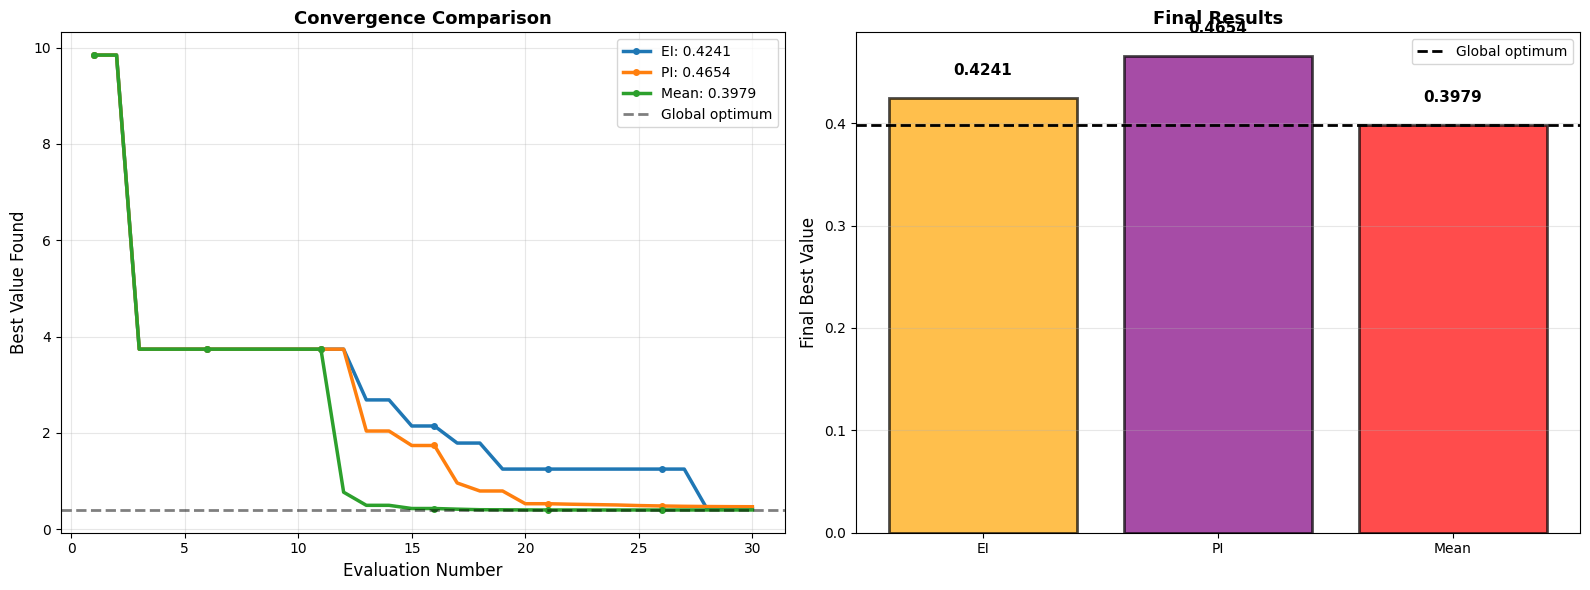


📊 Summary:
   EI    : 0.424132
   PI    : 0.465398
   Mean  : 0.397890
   Global: 0.397887

💡 EI typically achieves best balance


In [7]:
# Run optimizations with different acquisition functions
acquisitions = {
    'EI': 'ei',
    'PI': 'pi',
    'Mean': 'y'  # Pure exploitation
}

results_acq = {}

for name, acq in acquisitions.items():
    opt_acq = SpotOptim(
        fun=branin,
        bounds=[(-5, 10), (0, 15)],
        n_initial=10,
        max_iter=30,
        acquisition=acq,
        seed=42
    )
    result_acq = opt_acq.optimize()
    results_acq[name] = {
        'optimizer': opt_acq,
        'result': result_acq,
        'history': np.minimum.accumulate(opt_acq.y_)
    }

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Convergence
for name, data in results_acq.items():
    evals = np.arange(1, len(data['history']) + 1)
    ax1.plot(evals, data['history'], linewidth=2.5, label=f"{name}: {data['result'].fun:.4f}", marker='o', 
             markersize=4, markevery=5)

ax1.axhline(0.397887, color='black', linestyle='--', linewidth=2, label='Global optimum', alpha=0.5)
ax1.set_xlabel('Evaluation Number', fontsize=12)
ax1.set_ylabel('Best Value Found', fontsize=12)
ax1.set_title('Convergence Comparison', fontweight='bold', fontsize=13)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Final comparison
names = list(results_acq.keys())
final_values = [results_acq[name]['result'].fun for name in names]
colors_bar = ['orange', 'purple', 'red']

bars = ax2.bar(names, final_values, color=colors_bar, alpha=0.7, edgecolor='black', linewidth=2)
ax2.axhline(0.397887, color='black', linestyle='--', linewidth=2, label='Global optimum')
ax2.set_ylabel('Final Best Value', fontsize=12)
ax2.set_title('Final Results', fontweight='bold', fontsize=13)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, val in zip(bars, final_values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{val:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 Summary:")
for name, data in results_acq.items():
    print(f"   {name:6s}: {data['result'].fun:.6f}")
print(f"   Global: {0.397887:.6f}")
print(f"\n💡 EI typically achieves best balance")

## 6. Advanced Topics

### 6.1 Noisy Observations

When observations have noise, use **Augmented EI**:

$$\text{EI}_{\text{aug}}(x) = \mathbb{E}[\max(f^* - f(x) - \epsilon, 0)]$$

where $\epsilon \sim \mathcal{N}(0, \sigma_n^2)$ is observation noise.

### 6.2 Constrained Optimization

For constraints $g(x) \leq 0$, use **Constrained EI**:

$$\text{EI}_{\text{const}}(x) = \text{EI}(x) \cdot P(g(x) \leq 0)$$

Build separate GP for each constraint.

### 6.3 Multi-Objective Optimization

For multiple objectives $f_1, f_2, \ldots, f_m$:

- **Expected Hypervolume Improvement (EHVI)**
- **Probability of Pareto Improvement**
- **Scalarization approaches**

## 7. Practical Recommendations

### When to Use Each Acquisition Function

| Function | Use When | Pros | Cons |
|----------|----------|------|------|
| **EI** | Default choice | Balanced, well-studied | Requires tuning $\xi$ |
| **PI** | Need simplicity | Fast, intuitive | Overly exploitative |
| **LCB/UCB** | Need explicit control | Direct $\kappa$ tuning | Less automatic balance |
| **Mean (y)** | Pure exploitation | Fastest convergence | No exploration |

### Parameter Guidelines

**Expected Improvement ($\xi$):**
- Default: $\xi = 0.01$ (small exploration bonus)
- More exploration: $\xi = 0.1$ to $1.0$
- Pure exploitation: $\xi = 0$

**LCB/UCB ($\kappa$):**
- Conservative: $\kappa = 1.0$
- Balanced: $\kappa = 2.0$ (recommended)
- Aggressive exploration: $\kappa = 3.0$ to $5.0$

### SpotOptim Configuration

In [8]:
# Example configurations

# 1. Conservative (fast convergence, risk of local minima)
opt_conservative = SpotOptim(
    fun=branin,
    bounds=[(-5, 10), (0, 15)],
    acquisition='pi',  # More exploitative
    n_initial=20,      # More initial data
    seed=42
)

# 2. Balanced (recommended)
opt_balanced = SpotOptim(
    fun=branin,
    bounds=[(-5, 10), (0, 15)],
    acquisition='ei',  # Default
    n_initial=10,
    seed=42
)

# 3. Exploratory (better global search, slower)
opt_exploratory = SpotOptim(
    fun=branin,
    bounds=[(-5, 10), (0, 15)],
    acquisition='ei',
    n_initial=5,       # Less initial data
    seed=42
)

print("✓ Example configurations defined")
print("\n💡 Choose based on:")
print("   - Function evaluation cost (expensive → more exploration)")
print("   - Problem complexity (many local minima → more exploration)")
print("   - Time budget (limited → more exploitation)")

✓ Example configurations defined

💡 Choose based on:
   - Function evaluation cost (expensive → more exploration)
   - Problem complexity (many local minima → more exploration)
   - Time budget (limited → more exploitation)


## 8. Summary: Complete Workflow

### The Bayesian Optimization Loop

```python
1. Initialize with LHD         # Tutorial 1
   ↓
2. Fit surrogate (GP)          # Tutorial 2
   ↓
3. Optimize acquisition        # Tutorial 3 & 5
   ↓
4. Evaluate true function
   ↓
5. Update dataset
   ↓
6. Visualize progress          # Tutorial 4
   ↓
7. Check convergence → Repeat or Stop
```

### Key Takeaways

✅ **Acquisition Functions:**
- Balance exploration and exploitation
- EI is best default choice
- Tune parameters based on problem characteristics

✅ **Theory to Practice:**
- Mathematical formulations guide implementation
- Understanding components helps debugging
- Visualization reveals behavior

✅ **SpotOptim Integration:**
- Handles acquisition function optimization internally
- Configurable via `acquisition` parameter
- Works seamlessly with surrogate models

### References

1. **Forrester, Sóbester, & Keane (2008)**  
   *Engineering Design via Surrogate Modelling*  
   Comprehensive coverage of surrogate-based optimization

2. **Shahriari et al. (2016)**  
   *Taking the Human Out of the Loop: A Review of Bayesian Optimization*  
   Modern review of BO methods

3. **Bartz, T. et al. (2023-2025)**  
   *Sequential Parameter Optimization*  
   [Hyperparameter Tuning Cookbook](https://sequential-parameter-optimization.github.io/Hyperparameter-Tuning-Cookbook/)

---

## 🎉 Congratulations!

You've completed the **Surrogate-Based Optimization Tutorial Series**!

**What you've learned:**
1. ✅ Efficient sampling with Latin Hypercube Design
2. ✅ Building Gaussian Process surrogates
3. ✅ Balancing exploration and exploitation
4. ✅ Visualizing optimization progress
5. ✅ Understanding acquisition functions deeply

**Next steps:**
- Apply to your own problems
- Experiment with different acquisition functions
- Explore advanced features in SpotOptim
- Read the references for deeper understanding

---

**Series Navigation:**
- [Tutorial 1: Sampling Plans](01_sampling_plans_lhd.ipynb)
- [Tutorial 2: Constructing Surrogates](02_constructing_surrogate.ipynb)
- [Tutorial 3: Exploring and Exploiting](03_exploring_exploiting.ipynb)
- [Tutorial 4: Visualization](04_visualization.ipynb)
- [Tutorial 5: Infill Criteria](05_infill_criteria.ipynb) ⬅️ You are here